# Problem Set 5, due Nov 13 at 11:59pm.

As usual, you are highly encouraged to start this problem set early.  You have considerable flexibility in how creative you wish to be with this problem set.

## Part 1: Exploring the Titanic

Your mission for this problem set is to use your knowledge of supervised machine learning to try to predict which passengers aboard the Titanic were most likely to survive. The prompts for this part of the problem set are deliberately vague - the goal is to leave it up to you how to structure (most of) your analysis.

To get started, read about the prediction problem on [Kaggle](https://www.kaggle.com/c/titanic). Then, download the data [here](https://www.kaggle.com/c/titanic/data) - you'll want at least the train and test data, maybe more.

### 1.1 Exploratory data analysis

Create 2-3 figures and tables that help give you a feel for the data. Make sure to at least check the data type of each variable, to understand which variables have missing observations (and to formulate a plan for dealing with them), and to understand the distribution of each variable (and determine whether the variables should be normalized or not). Are any variables collinear or highly correlated?

In [1]:
import IPython
import numpy as np
import scipy as sp
import pandas as pd
import matplotlib
import sklearn
import os
import time
import seaborn as sns

from scipy.interpolate import griddata

%matplotlib inline  
import matplotlib.pyplot as plt  
from mpl_toolkits.mplot3d import Axes3D
import random

import scipy.stats as ss

import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.tools import eval_measures

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_validate
from sklearn import preprocessing
from sklearn import metrics
from sklearn.metrics import accuracy_score

random_state=13579
np.random.seed(seed=random_state)

c:\program files\python 3.5\lib\site-packages\statsmodels\compat\pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [2]:
# enter your code here
import pandas as pd

train_data = pd.read_csv("train.csv",index_col='PassengerId')

print("Train Data Head")
print(train_data.head(5))
print("------------------------------------------------------------------------------------\n")

print("Train Data Data Types")
print(train_data.dtypes)
print("------------------------------------------------------------------------------------\n")

print("Train Data Descriptive Stats")
print(train_data.describe(include="all"))
print("------------------------------------------------------------------------------------\n")

test_data = pd.read_csv("test.csv",index_col='PassengerId')
print("Test Data Descriptive Stats")
print(test_data.describe(include="all"))
print("------------------------------------------------------------------------------------\n")

total_data = pd.concat([train_data,test_data])
# print("Total Data Descriptive Stats")
# print(total_data.describe(include="all"))
# print("------------------------------------------------------------------------------------\n")


print("Sum of NANs in Training Data")
print(train_data.isnull().sum())
print("------------------------------------------------------------------------------------\n")

print("Sum of NANs in Testing Data")
print(test_data.isnull().sum())
print("------------------------------------------------------------------------------------\n")

Train Data Head
             Survived  Pclass  \
PassengerId                     
1                   0       3   
2                   1       1   
3                   1       3   
4                   1       1   
5                   0       3   

                                                          Name     Sex   Age  \
PassengerId                                                                    
1                                      Braund, Mr. Owen Harris    male  22.0   
2            Cumings, Mrs. John Bradley (Florence Briggs Th...  female  38.0   
3                                       Heikkinen, Miss. Laina  female  26.0   
4                 Futrelle, Mrs. Jacques Heath (Lily May Peel)  female  35.0   
5                                     Allen, Mr. William Henry    male  35.0   

             SibSp  Parch            Ticket     Fare Cabin Embarked  
PassengerId                                                          
1                1      0         A/5 21171   7.250

Text(0.5,0.98,'Scatter Titanic Training Data')

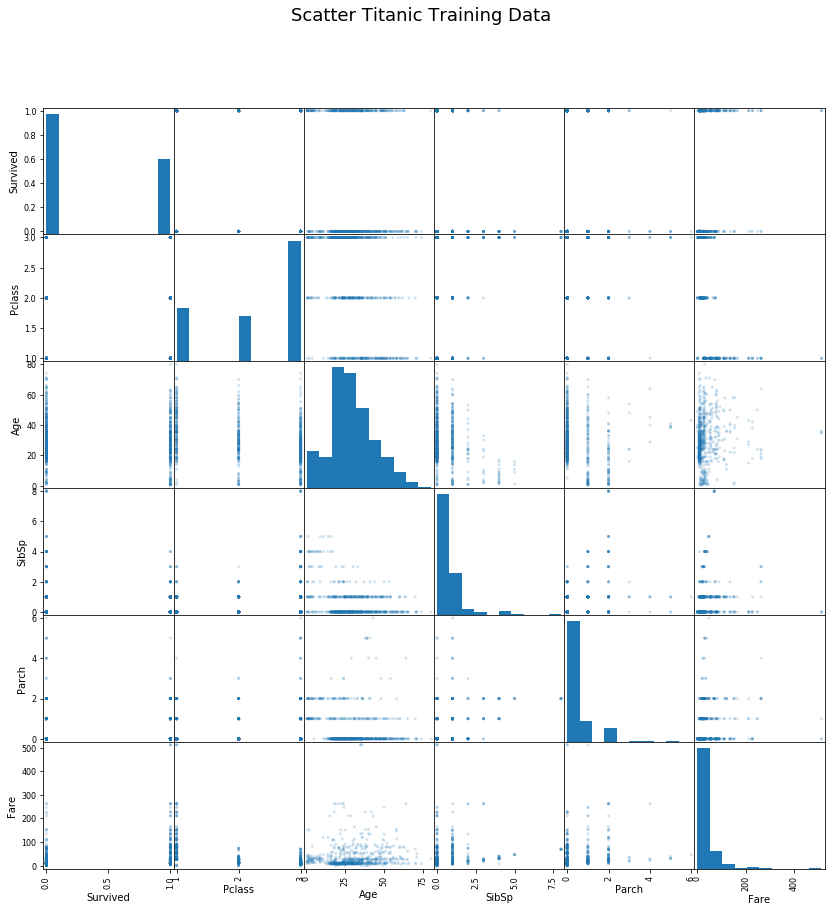

In [3]:
#from PS1
#Use scatter matrix to view the data types and distributions
fig = pd.plotting.scatter_matrix(train_data, alpha=0.2,figsize=(14, 14), diagonal='hist')
plt.suptitle('Scatter Titanic Training Data', fontsize=18)



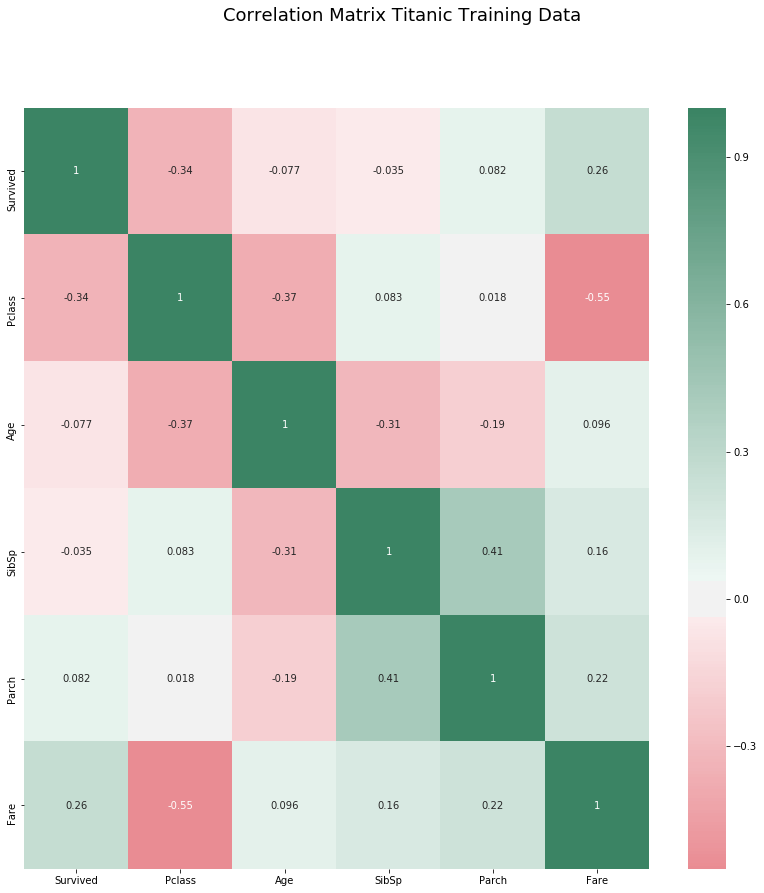

In [4]:
#use correlation matrix to check for colinearity
#use seaborn which is much better than what I used in the first problem set
fig = plt.figure(figsize=(14,14))
CorMat = train_data.corr()
sns.heatmap(CorMat, annot=True, center=0, cmap = sns.diverging_palette(h_neg=10, h_pos =150,n=10, center="light", as_cmap=True));
plt.suptitle('Correlation Matrix Titanic Training Data', fontsize=18)
plt.show()


# ####old code --- ugly
# plt.matshow(CorMat,cmap='RdYlGn')
# plt.xticks(range(len(CorMat.columns)), CorMat.columns)
# plt.yticks(range(len(CorMat.columns)), CorMat.columns)
# plt.colorbar()
# ax = plt.gca()
# for tick in ax.get_xticklabels():
#     tick.set_rotation(90)
# plt.tick_params(axis='x',which='both',top='off',bottom="off") # labels along the bottom edge are off
# plt.tick_params(axis='y',which='both',right='off',left="off") # labels along the bottom edge are off
# plt.suptitle('Correlation Matrix Titanic Training Data', fontsize=18)
# plt.show()

## Findings
#### Variable types
- Only fare and age seem to be continuous variables, and we can normalize these.
- Name, sex, ticket, cabin and embarked are categorical variables. I will create dummy variables for sex. Name, ticket and cabin have multiple unique values and thus it would not make sense to dummy them.
- Categorical values that are ordinal are: Survived, Pclass, SibSp, Parch.

#### Colinearity
There is slight correlation (negative) between Fare and Pclass (assuming passenger class), which makes sense, and you can see that at some point tickets probably went for a lot of money just so people could get on this famous boat. Other than that I would not say there is much colinearity.

#### Missing Values
There are NANs in AGE and Cabin. From what I know about the Titanic, age played a role in how they populated the emergency boats, but more importantly gender played a very important role. Thus the NANs are an issue in age. If we can figure out gender that would be good. In terms of figuring out age, (and some research on the net), it seems that there are some key words in NAME, like Mr, Mrs, Miss, Master etc that could be usefuly for indicating whether someone it older or younger than 18. I'll look at this and instead of populating the missing age values perhaps create a new variable where I combine title and age.

The NANs in CABIN are just too plentiful. I think the info would be useful, but there is no way to guess where a person stayed on the boat, especially with so many missing values. Quite frankly I am going to drop the whole CABIN column as I don't see a good way of filling it.

#### Correlation observations
We don't have dummy variables yet, but Pclass and fare seems to have some correlation, but not much.



In [5]:
#create bag of words using name to see if there is any pattern
#first drop some of the punctuation
train_data['Name']=train_data['Name'].str.lower()
train_data["NewName"] = train_data['Name'].str.replace('[^\w\s]','')
bag_of_words = pd.Series([y for x in train_data['NewName'].values.flatten() for y in x.split()]).value_counts()
print('First 11 Bag of words items using Name')
print(bag_of_words[:10])
print(len(bag_of_words))
print('\n')
train_data["Title"] = 'other'
Title_List = ['mr','miss','master','mrs']


#based on research Master is a boy of age < 18
#Miss generally refers to an unmarried female, age could vary
# Mr is generally male above 18
# Mrs is married female
#summing totals of Mr, Miss, Mrs and Master we get 872, which is quite good given we have 891 observations in total
#so let's create a new variable called title and also try and fill our NaNs in age

#just picked up that we have other titles such as don, rev, dr, mme, jonkheer, capt, countess, mlle,col,ms
#some of these are male, some are female

def createTitle(x,List):
    title = 'other'
    for l in List:
        if l in x["NewName"]:
            title = l
    
    if title == 'other':
        if x["Sex"]=="male":
            if x["Age"] >= 18:
                title = 'mr'
            elif x["Age"] < 18:
                title = 'master'
            else:
                title = 'mr'
        if x["Sex"]=="female":
            if x["Age"] >= 18:
                title = 'mrs'
            elif x["Age"] < 18:
                title = 'miss'
            else:
                title = 'mrs'
    
    return title

def fixAge(x):
    age = x['Age']
    if str(age)=='nan':
        if x['Sex'] == 'female':
            if x['Title'] == 'mrs':
                age = 40
            elif x['Title'] == 'miss':
                age = 10
        else:
            if x['Title'] == 'mr':
                age = 35
            elif x['Title'] == 'master':
                age = 10

# print(train_data.groupby("Title").mean())                
#         Survived    Pclass        Age     SibSp     Parch       Fare
# Title                                                               
# master  0.560976  2.585366   4.574167  2.243902  1.341463  34.822561
# miss    0.700000  2.311111  21.777778  0.722222  0.555556  44.067849
# mr      0.160448  2.375000  32.984412  0.291045  0.151119  24.812615
# mrs     0.798507  1.955224  35.470085  0.656716  0.776119  45.033209
    return age


train_data["Title"] = train_data[["NewName","Age","Sex"]].apply(createTitle,List=Title_List,axis=1)
#fix age based on title...bit of a hack
train_data["Age"] = train_data[["Title","Age","Sex"]].apply(fixAge,axis=1)

print("Number of observations with missing age after our cleanup")
print(train_data["Age"].isnull().sum())
print('\n')
print("Title Column Count")
print(train_data["Title"].value_counts())


test_data['Name']=test_data['Name'].str.lower()
test_data["NewName"] = test_data['Name'].str.replace('[^\w\s]','')
test_data["Title"] = 'other'
test_data["Title"] = test_data[["NewName","Age","Sex"]].apply(createTitle,List=Title_List,axis=1)

First 11 Bag of words items using Name
mr         521
miss       182
mrs        129
william     64
john        44
master      40
henry       35
james       24
george      24
charles     23
dtype: int64
1525


Number of observations with missing age after our cleanup
0


Title Column Count
mr        537
miss      180
mrs       134
master     40
Name: Title, dtype: int64


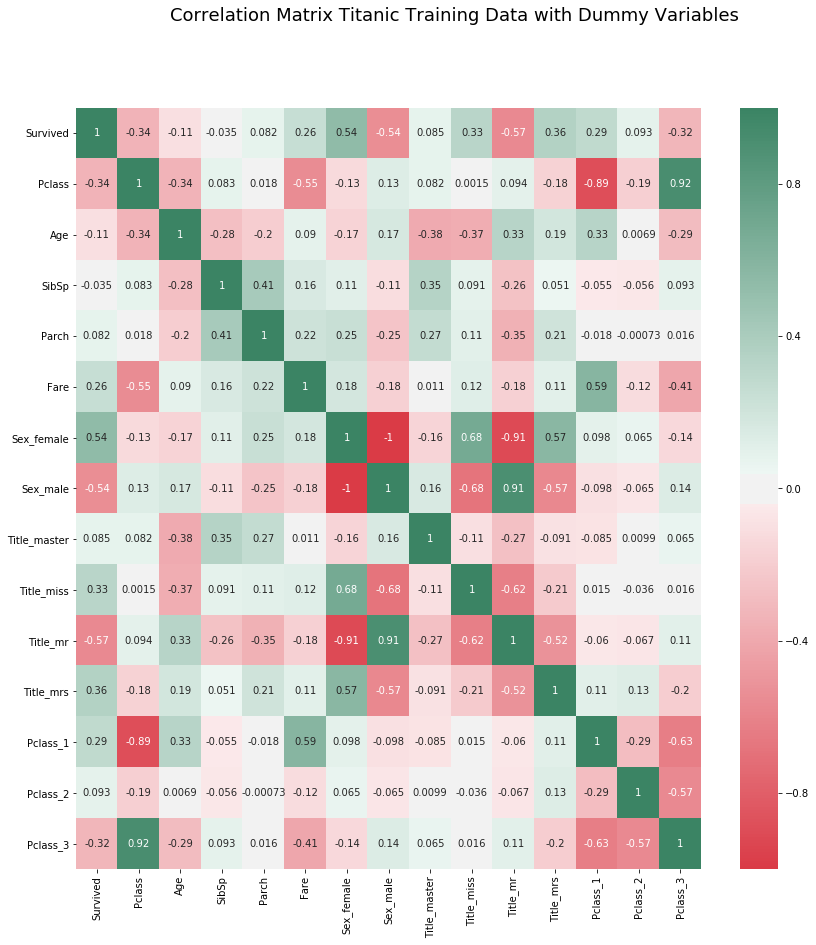

In [6]:

#create dummy variables and add them to our dataframe
def CreateOneHotVectors(CategoricalVars,dataFrame):
    dtypeCount =[dataFrame.iloc[:,i].apply(type).value_counts() for i in range(dataFrame.shape[1])]
    DummyDict ={}
    DummyCatVars = []
    for name in CategoricalVars:
        dummies = pd.get_dummies(dataFrame[name], prefix = name ).applymap(np.int)
        DummyDict[name] = dummies.columns.values.tolist()
        DummyCatVars+= dummies.columns.values.tolist()
        dataFrame = pd.concat([dataFrame,dummies],axis=1)
    return dataFrame.copy(),DummyCatVars

DummyCatVars = []

#create a list of categorical vars, which we will convert to dummies
#since pclass is really an ordinal variable I am going to one_hot encode it too
CategoricalVars = ['Sex','Title','Pclass']

new_train_data, DummyCatVars = CreateOneHotVectors(CategoricalVars,train_data)
new_test_data, DummyCatVars = CreateOneHotVectors(CategoricalVars,test_data)

#use correlation matrix to check for colinearity
#use seaborn which is much better than what I used in the first problem set
fig = plt.figure(figsize=(14,14))
CorMat = new_train_data.corr()
sns.heatmap(CorMat, annot=True, center=0, cmap = sns.diverging_palette(h_neg=10, h_pos =150,n=10, center="light", as_cmap=True));
plt.suptitle('Correlation Matrix Titanic Training Data with Dummy Variables', fontsize=18)
plt.show()



## More findings
Male, female and title seem to have interesting correlations with survival.

Interesting variables to explore: sex, title, pclass, fare, age

### 1.2 Correlates of survival

Use whatever methods you can think of to try and figure out what factors seem to determine whether or not a person would survive the sinking of the Titanic. What do you conclude?

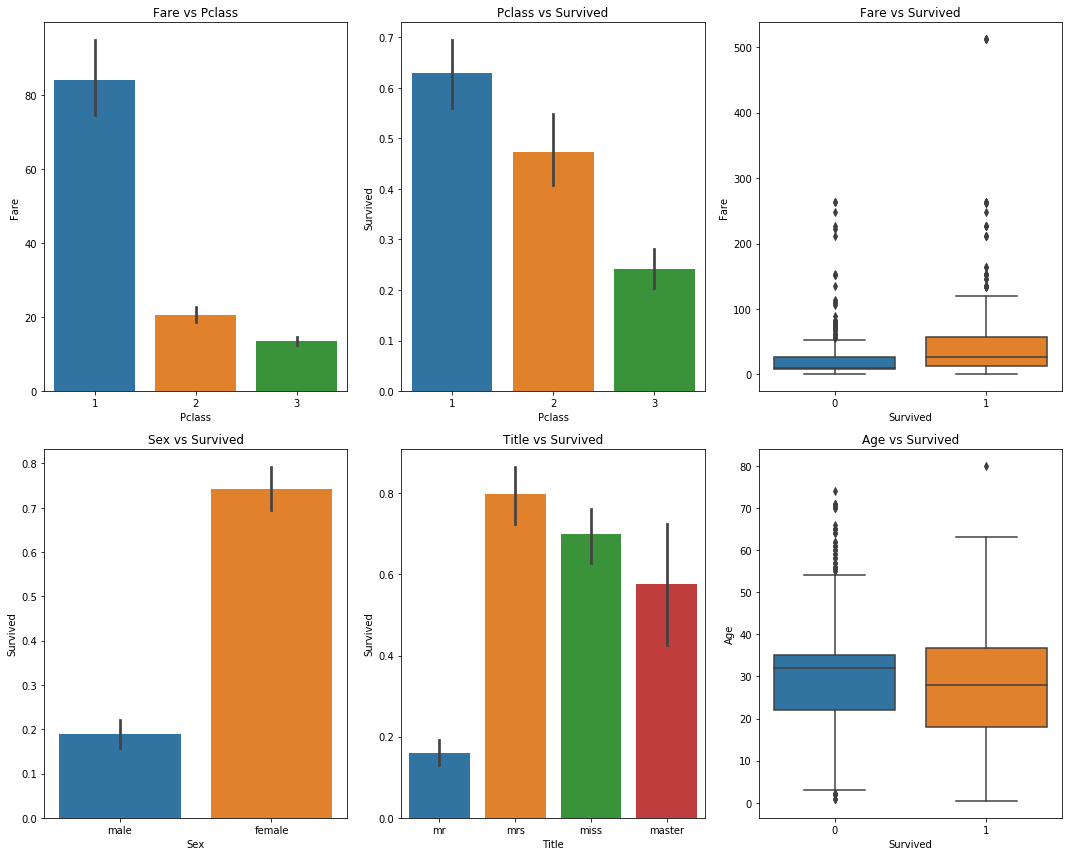

In [7]:
# enter your code here
#we've already looked at the correlations so there are some variables that I'm interested in
#let's look how our dummy data stacks up against survival or not
# #what I would like to see is just a visual plot of each variable vs survived
fig, axes = plt.subplots(2, 3, figsize=(15, 12))
sns.barplot(x='Pclass', y='Fare',data=new_train_data,ax=axes[0,0]).set_title("Fare vs Pclass")
sns.barplot(x='Pclass', y='Survived',data=new_train_data,ax=axes[0,1]).set_title("Pclass vs Survived")
# sns.kdeplot(data=new_train_data['Fare'].values, data2=new_train_data['Survived'].values,ax=axes[0,2]).set_title("KDE: Fare vs Survived")
sns.boxplot(x='Survived', y='Fare',data=new_train_data,ax=axes[0,2]).set_title("Fare vs Survived")
sns.barplot(x='Sex', y='Survived',data=new_train_data,ax=axes[1,0]).set_title("Sex vs Survived")
sns.barplot(x='Title', y='Survived',data=new_train_data,ax=axes[1,1]).set_title("Title vs Survived")
sns.boxplot(x='Survived', y='Age',data=new_train_data,ax=axes[1,2]).set_title("Age vs Survived")

plt.tight_layout()
plt.show()

# print("Show total number of items vs Survived")
# DummyPlusSurvived = list(set(DummyCatVars))
# DummyPlusSurvived.append("Survived")
# print(new_train_data[DummyPlusSurvived].groupby("Survived").sum())






### Observations
Sex, Title, Pclass and Fare seem to indicate good predictive power, whereas Age does not seem to help much. That said removing age from the equation gives me training scores of 80% and test scores of 77% for CV and adding it in increases these to 88% and 81%.

As mentioned above Pclass and Fare seems to be colinear, so I'll remove Fare from the equation. I also expect some colinearity between sex and title, just by way of construction. However, let's see what happens when we keep both.

## Part 2: Decision Trees

... Because how can you take a course in Applied Machine Learning without fitting a decision tree?

### 2.1 Decision Tree
Using the basic [Decision Tree](http://scikit-learn.org/stable/modules/tree.html#tree) library in sklearn, fit a model to predict titanic survival. Make sure you come up with an appropriate way of handling each of the input variables before feeding them in to the decision tree. You can use the [DecisionTreeClassifier](http://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html#sklearn.tree.DecisionTreeClassifier) method to implement 10-fold cross-validation. Report the average training and testing accuracy across your 10 folds, and show a diagram of the tree (at least the first three levels).


In [8]:
# Enter your code here


#first we do some encoding to turn our categorical vars into numerical vars
#we can use our dummy vectors, but this leads to funny behaviour e.g. that there could be two decisions to decide on female
#first say male is 0 and then female is 1, which is arbitrary for a decision tree
new_total_data = pd.concat([new_train_data,new_test_data])
encoder_dict = {}
TreeVars = []
for var in CategoricalVars:
    encoder_dict[var] = preprocessing.LabelEncoder()
    encoder_dict[var].fit(new_total_data[var])
    TreeVar = var+"_enc"
    TreeVars.append(TreeVar)
    new_train_data[TreeVar] = encoder_dict[var].transform(new_train_data[var]) 
    new_test_data[TreeVar] = encoder_dict[var].transform(new_test_data[var])
    print("Unique " +str(var) +" values and encodings")
    print("Unique values "+str(var) + str(new_train_data[var].unique()))
    print("Encoded values " +str(var) + str(encoder_dict[var].transform(new_total_data[var].unique())))
    print("\n")

print(new_train_data.head(5))


Unique Sex values and encodings
Unique values Sex['male' 'female']
Encoded values Sex[1 0]


Unique Title values and encodings
Unique values Title['mr' 'mrs' 'miss' 'master']
Encoded values Title[2 3 1 0]


Unique Pclass values and encodings
Unique values Pclass[3 1 2]
Encoded values Pclass[2 0 1]


             Survived  Pclass  \
PassengerId                     
1                   0       3   
2                   1       1   
3                   1       3   
4                   1       1   
5                   0       3   

                                                          Name     Sex   Age  \
PassengerId                                                                    
1                                      braund, mr. owen harris    male  22.0   
2            cumings, mrs. john bradley (florence briggs th...  female  38.0   
3                                       heikkinen, miss. laina  female  26.0   
4                 futrelle, mrs. jacques heath (lily may peel)  fem



DecisionTreeClassifier Cross Validation
Average Training score 0.8812825553
Average Test score:  0.812654352514


DTC fit to random 90% of data and then plotted


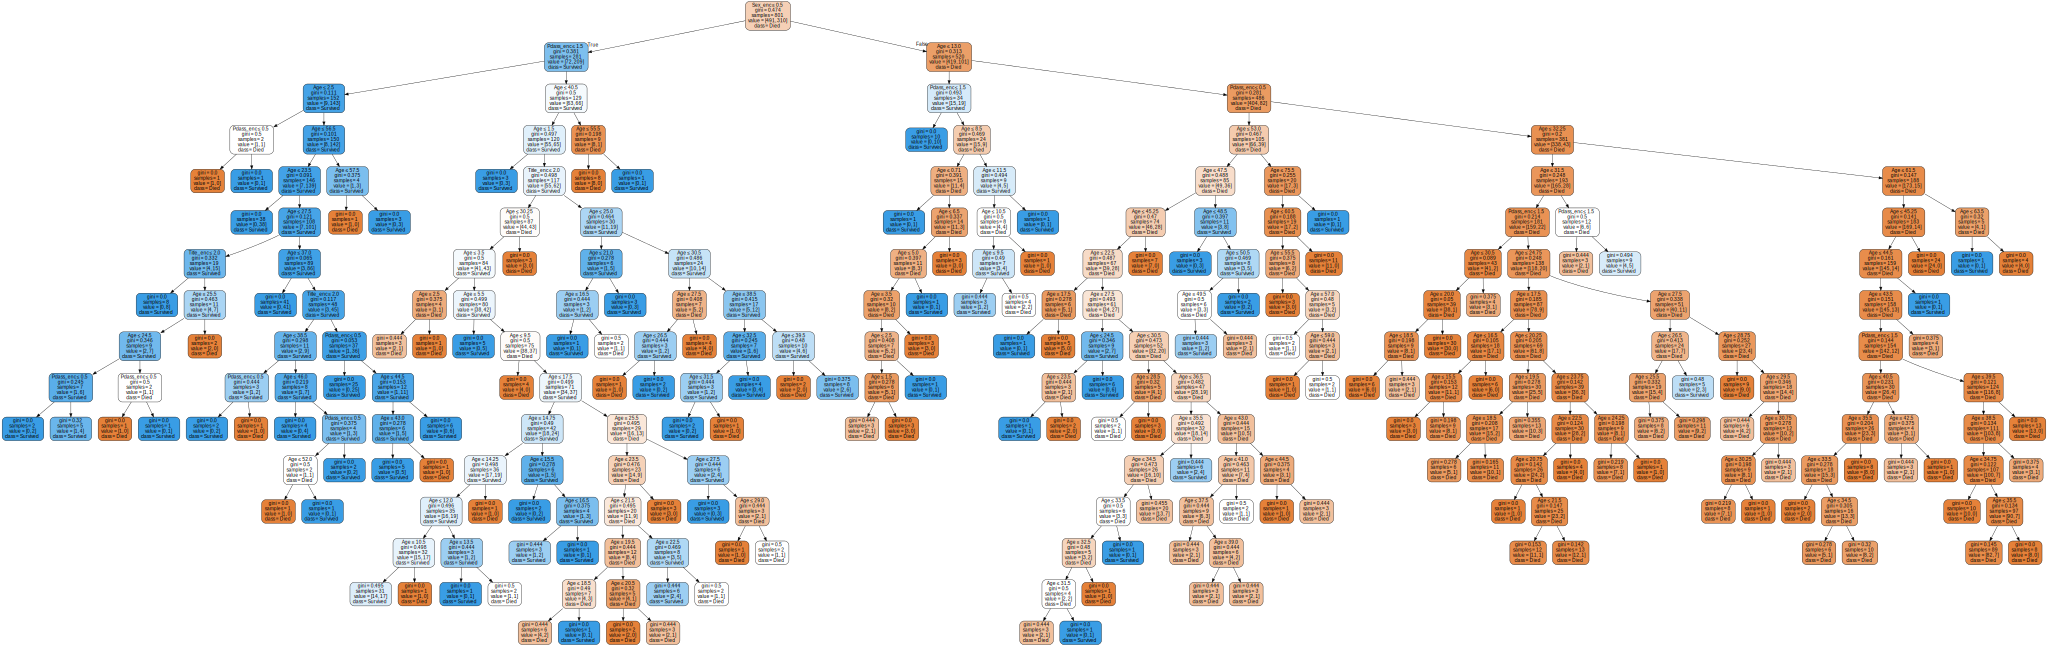

In [9]:
#first we fit the clf using cross validation
InterestingVars = list(set(TreeVars))
InterestingVars.append("Age")
maxTreeDepth = 500
min_samples_leaf = 15
clf = DecisionTreeClassifier(random_state=random_state)

print("\n")
print("DecisionTreeClassifier Cross Validation")
accuracy_scorer = metrics.make_scorer(accuracy_score)
results = cross_validate(clf, new_train_data[InterestingVars], new_train_data['Survived'], scoring = accuracy_scorer, cv=10, return_train_score=True)
print('Average Training score', np.mean(results['train_score']))
print('Average Test score: ', np.mean(results['test_score']))
print("\n")


#now we fit a tree to the data, 90% of it, to mimic one of our trees and plot it
fullList =  list(set(np.random.permutation(len(new_train_data))[0:int(0.9*len(new_train_data.index.values))]))
trainDataFold = new_train_data.iloc[fullList]
clf.fit(trainDataFold[InterestingVars], trainDataFold['Survived'])

print("DTC fit to random 90% of data and then plotted")

#visualization
import graphviz 
dot_data = tree.export_graphviz(clf, out_file=None, 
                         feature_names=InterestingVars,  
                         class_names=["Died","Survived"],  
                         filled=True, rounded=True,  
                         special_characters=True)  
graph = graphviz.Source(dot_data) 
graph



### Observations
Encoder shows male as 1 and female as 0.

Encoder shows mr as 2, mrs as 3, miss as 1 and master as 0

Encoder shows Pclass 3 as 2, Pclass 1 as 0 and Pclass 2 as 1

Our CV accuracy on the training data is roughly 88% with the average test score being 81.26%. This is after I added age back into the mix, without age, the max tree depth is four by default. 

### 2.2 Tree tuning

Use all of the data to re-fit a single decision tree with max_depth = 4 (i.e., no cross-validation). Show the tree diagram and also plot the feature importances. What do you observe?

DTC fit to full train data with maxTreeDepth = 4
Training accuracy score 0.811447811448


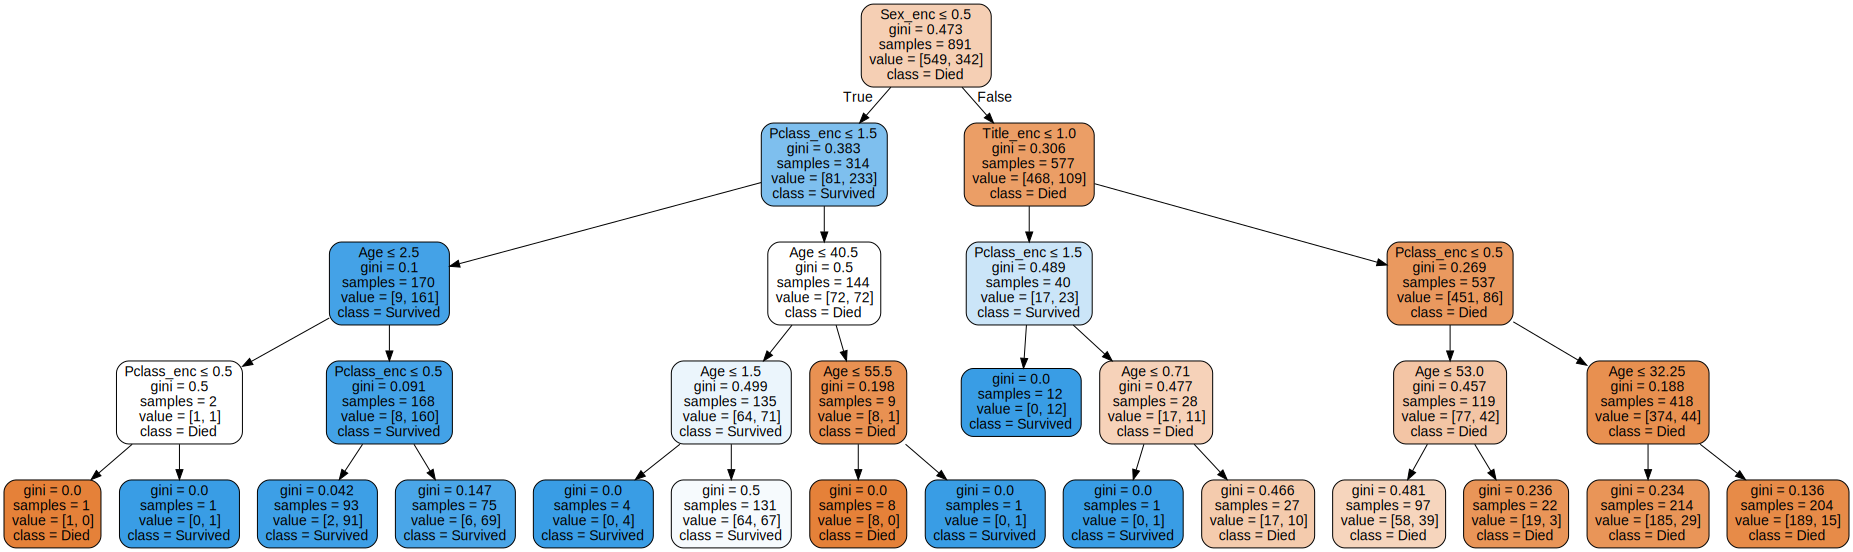

In [10]:
# Enter your code here
maxTreeDepth = 4
min_samples_leaf = 15
clf = DecisionTreeClassifier(max_depth=maxTreeDepth,random_state=random_state)
clf.fit(new_train_data[InterestingVars], new_train_data['Survived'])
print("DTC fit to full train data with maxTreeDepth = 4")
print('Training accuracy score ' + str(metrics.accuracy_score(y_pred = clf.predict(new_train_data[InterestingVars]),
                                                             y_true = new_train_data['Survived'])))

#visualization
import graphviz 
dot_data = tree.export_graphviz(clf, out_file=None, 
                         feature_names=InterestingVars,  
                         class_names=["Died","Survived"],  
                         filled=True, rounded=True,  
                         special_characters=True)  
graph = graphviz.Source(dot_data) 
graph


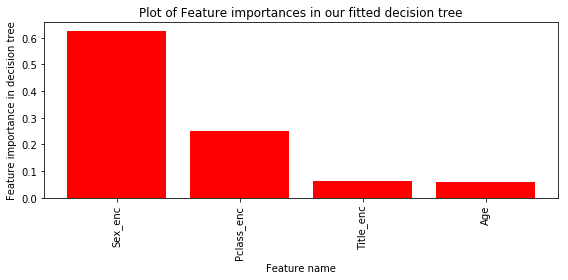

In [11]:

Feature_importance_col = list(zip(InterestingVars,clf.feature_importances_))
Feature_importance_col = sorted(Feature_importance_col, key=lambda x: x[1],reverse=True)
Feature_Name,Feature_imp = zip(*Feature_importance_col)

# print(InterestingVars)
#added this once I saw the comparison down below
# Show feature importance
Feature_Importance = pd.DataFrame(data = clf.feature_importances_, index = InterestingVars, columns = ['Tree'])

#bar plot
numCols = len(Feature_importance_col)
fig,ax = plt.subplots(figsize=(8,4))
ax.bar(range(numCols), Feature_imp, width=0.8, color='r')
ax.set_xticks(np.arange(numCols)+0)  # set the x ticks to be at the middle of each bar since the width of each bar is 0.8
ax.set_xticklabels(Feature_Name)  #replace the name of the x ticks with your Groups name
plt_name = "Plot of Feature importances in our fitted decision tree"
ax.set_title(plt_name)
ax.set_xlabel('Feature name')
ax.set_ylabel('Feature importance in decision tree')
ax.tick_params(axis='x',which='both',top='off') # labels along the bottom edge are off
ax.tick_params(axis='y',which='both',right='off') # labels along the bottom edge are off
for tick in ax.get_xticklabels():
    tick.set_rotation(90)
fig.tight_layout()
plt.show()


*Enter your observations here*

After we trimmed the tree to four levels (top node is level 0) the training score dropped from 88% to 81%. Feature importance says that sex is most important, from our data we can see being a female matters most, after this class followed by title and age.

### 2.3 Sensitivity analysis
The built-in algorithm you are using has several parameters which you can tune. Using cross-validation, show how the choice of these parameters affects performance.

First, show how max_depth affects train and test accuracy. On a single axis, plot train and test accuracy as a function of max_depth. Use a red line to show test accuracy and a blue line to show train accuracy.

Second, show how test accuracy relates to both max_depth and min_samples_leaf. Specifically, create a 3-D plot where the x-axis is max_depth, the y-axis is min_samples_leaf, and the z-axis shows accuracy. What combination of max_depth and min-samples_leaf achieves the highest accuracy? How sensitive are the results to these two parameters?

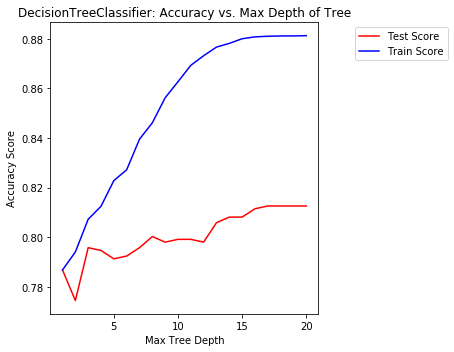

In [14]:
maxTreeDepthArray = [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20] 

parameters = {'max_depth':maxTreeDepthArray,'random_state':[random_state]}
GridCLF = GridSearchCV(estimator=DecisionTreeClassifier(), param_grid = parameters, scoring='accuracy', cv=10, verbose=0)
GridCLF.fit(new_train_data[InterestingVars],new_train_data['Survived'])
GridRes = pd.DataFrame(GridCLF.cv_results_)
test_score = GridRes['mean_test_score']
train_score = GridRes['mean_train_score']

fig, ax = plt.subplots(figsize = (5,5))

ax.plot(maxTreeDepthArray, test_score, color = 'r',  label = 'Test Score')
ax.plot(maxTreeDepthArray, train_score, color = 'b',  label = 'Train Score')
ax.set_xlabel('Max Tree Depth')
ax.set_ylabel('Accuracy Score')
ax.legend(loc='upper right', bbox_to_anchor=(1.5, 1))
ax.set_title('DecisionTreeClassifier: Accuracy vs. Max Depth of Tree')

plt.tight_layout()
plt.show()



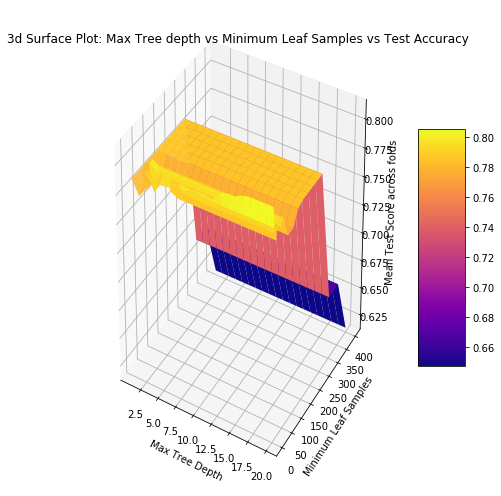

In [15]:
maxTreeDepthArray = [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20] 
min_samples_leafArray = [1,5,10,15,20,25,30,35,40,45,50,75,100,125,150,175,200,225,250,300,350,400]


#https://stackoverflow.com/questions/9170838/surface-plots-in-matplotlib
#http://matplotlib.org/examples/mplot3d/surface3d_demo.html
#so we need to create a meshgrid for the 3d plot. 



x = np.asarray(maxTreeDepthArray)
y = np.asarray(min_samples_leafArray)
X, Y = np.meshgrid(x, y)

#test np implementation, not quite gridsearch but gives the same results
zs = np.array([np.mean(cross_validate(DecisionTreeClassifier(random_state=random_state,max_depth=x,min_samples_leaf=y),
                              new_train_data[InterestingVars], new_train_data['Survived'],
                              scoring = accuracy_scorer, cv=10, return_train_score=False)["test_score"])
               for x,y in zip(np.ravel(X), np.ravel(Y))])

Z = zs.reshape(X.shape)
fig = plt.figure(figsize = (7,7))
ax = fig.add_subplot(111, projection='3d')
surface = ax.plot_surface(X, Y, Z,cmap = 'plasma')

fig.colorbar(surface, shrink=0.5, aspect=5)
ax.set_xlabel('Max Tree Depth')
ax.set_ylabel('Minimum Leaf Samples')
ax.set_zlabel('Mean Test Score across folds')
ax.set_title('3d Surface Plot: Max Tree depth vs Minimum Leaf Samples vs Test Accuracy')

plt.tight_layout()
plt.show()



In [16]:
maxTreeDepthArray = [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20] 
min_samples_leafArray = [1,5,10,15,20,25,30,35,40,45,50,75,100,125,150,175,200,225,250,300,350,400]
parameters = {'max_depth':maxTreeDepthArray,'min_samples_leaf':min_samples_leafArray,'random_state':[random_state]}
GridDCT = GridSearchCV(estimator=DecisionTreeClassifier(), param_grid = parameters, scoring='accuracy', cv=10, verbose=0)
GridDCT.fit(new_train_data[InterestingVars],new_train_data['Survived'])
GridDCTRes = pd.DataFrame(GridDCT.cv_results_)
print('Best Model :'+str(GridDCT.best_estimator_))


Best Model :DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=17,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False,
            random_state=13579, splitter='best')


*Enter your observations here*
### 2d plot
As we increase the max tree depth we see the training accuracy far outperforming the testing outperforming, which is a likely indication of overfitting. I'm seeing better performance between 3 and 5 levels. Combining the feature importance, we then also see that given the importance of sex and pclass, it could make sense to have a tree with fewer features in any case, which would imply having fewer levels too.

### 3d plot
As we increase the minimum number of samples per leaf training accuracy gets worse across the board. There seems to be a flat spot around 200 to 300 where accuracy does not get worse by much and this could be a nice place to focus on if we want to get a model that generalizes well and is not too overfit. However, this parameter would serve a similar function as max tree depth, depending on the size of the training data, so clearly at very large numbers accuracy just falls through the floor as there really is not much for the model to train on.
Regarding maximum tree depth, at 1 or 2 the model seems to underperform, i.e. it suffers from underfitting, whereas at 20 there is clearly some overfitting.

### 2.4 Logistic Regression, for comparison
Use a 10-fold cross-validated logistic regression predict survival. Make sure you come up with an appropriate way of handling each of the input variables before feeding them in to the regression. 
* How does the performance of this model compare to the decision tree?
* How do the coefficients from the logistic regression compare to the feature importances from the decision tree? Create a scatter plot that shows this relationship (one dot for each variable, y-axis is feature importance, x-axis is....?)

In [17]:
# Enter your code here



#I've already created one hot encodings for sex, title and pclass
#now I will normalize age for logistic regression
#ideally I would like to use one hot encoding (where we drop one, but this makes the feature importance plot difficult)
#given that the size of the label encodings are quite small I'm just going to standardize them all
vars_to_standardize = ['Sex_enc','Pclass_enc','Title_enc','Age']
new_total_data = pd.concat([new_train_data,new_test_data])
std_dict = {}
StdVars = []
for var in vars_to_standardize:
    varName = str(var)+"_std"
    StdVars.append(varName)
    std_dict[varName]={}
    std_dict[varName]['mean'] = np.average(new_train_data[var])
    std_dict[varName]['stdev'] = np.std(new_train_data[var])
    new_train_data[varName] = (new_train_data[var]-std_dict[varName]['mean'])/std_dict[varName]['stdev']
    new_test_data[varName] = (new_test_data[var]-std_dict[varName]['mean'])/std_dict[varName]['stdev']
#     print(new_train_data[[varName,"Age"]])



In [18]:
LogitVars = list(set(StdVars))
# for i in StdVars:
#     LogitVars.append(i)
print(LogitVars)

['Pclass_enc_std', 'Title_enc_std', 'Sex_enc_std', 'Age_std']


In [19]:
#create the LogisticRegression model for CV

LogisticR = LogisticRegression()

parameters = {'C':[0.01,0.05,0.1,0.5,1,5,10]}
GridL = GridSearchCV(estimator=LogisticRegression(), param_grid = parameters, scoring=['accuracy','f1'],refit='accuracy',
                     cv=10, verbose=0)
GridL.fit(new_train_data[LogitVars],new_train_data['Survived'])
GridLRes = pd.DataFrame(GridL.cv_results_)
# print(GridLRes)
print('Best Model :'+str(GridL.best_estimator_))
print('Average Training score for best model: '+str(GridLRes['mean_train_accuracy'][GridLRes['rank_test_accuracy'] == 1].values))
print('Average Test score for best model: '+str(GridLRes['mean_test_accuracy'][GridLRes['rank_test_accuracy'] == 1].values))
# print(GridLRes)
# print(GridLRes.columns)

Best Model :LogisticRegression(C=0.01, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)
Average Training score for best model: [ 0.79423781]
Average Test score for best model: [ 0.79124579]


            Tree     Logit
Sex     0.626243  1.112570
Pclass  0.251676  0.863879
Title   0.064492  0.087348
Age     0.057590  0.328536


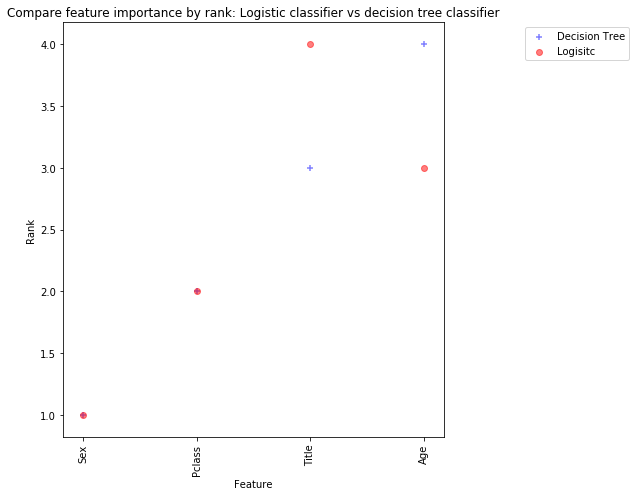

In [20]:
#we plotted feature importances for a decision tree fit to all training data, thus I will do the same and fit
#logistic regression to all training data
#this is a bit of a mess though, our variables don't align etc...
#https://stackoverflow.com/questions/34052115/how-to-find-the-importance-of-the-features-for-a-logistic-regression-model
#since we fit our model to standarized values we will just look at the size of the coefficients and the absolute size at that
LogisticR = LogisticRegression(C=0.1)
LogisticR.fit(new_train_data[LogitVars],new_train_data['Survived'])

Feature_Importance_log = pd.DataFrame(data = np.reshape(np.abs(LogisticR.coef_),(len(LogitVars),)), index = LogitVars, columns = ['Logit'])
#now we need to plot them on a graph
Feature_Importance_log = Feature_Importance_log.rename(index={'Sex_enc_std': 'Sex_enc',
                                                                'Pclass_enc_std': 'Pclass_enc',
                                                                'Age_std':'Age',
                                                                'Title_enc_std':'Title_enc' })


#now we reorder the columns to match feature_importance
Feature_comp = pd.concat([Feature_Importance, Feature_Importance_log], axis=1)
Feature_comp = Feature_comp.sort_values(by="Tree",ascending=False).copy()
Feature_comp = Feature_comp.rename(index={'Sex_enc': 'Sex','Pclass_enc': 'Pclass','Title_enc':'Title' })
print(Feature_comp)

fig = plt.figure(figsize = (7,7))
ax = plt.gca()
#ranking from https://stackoverflow.com/questions/3071415/efficient-method-to-calculate-the-rank-vector-of-a-list-in-python
x = np.arange(1,len(LogitVars)+1).astype(int)

y_logistic = ss.rankdata(Feature_comp["Logit"].values*-1).astype(int)
y_decision = ss.rankdata(Feature_comp["Tree"].values*-1).astype(int)
ax.scatter(x =x ,y= y_decision,marker='+', c='blue', alpha=0.5, label='Decision Tree')
ax.scatter(x =x ,y=y_logistic ,marker='o', c='red', alpha=0.5, label='Logisitc')

plt_name = "Compare feature importance by rank: Logistic classifier vs decision tree classifier"
ax.legend(loc='upper right', bbox_to_anchor=(1.5, 1))
ax.set_title(plt_name)
ax.set_xlabel('Feature')
ax.set_ylabel('Rank')
ax.tick_params(axis='x',which='both',top='off') # labels along the bottom edge are off
ax.tick_params(axis='y',which='both',right='off') # labels along the bottom edge are off
for tick in ax.get_xticklabels():
    tick.set_rotation(90)
plt.xticks(x, Feature_comp.index.values.tolist()) #replace the name of the x ticks with your Groups name
# ax.set_xticklabels(labels)
fig.tight_layout()
plt.show()


*Enter your observations here*
We can see that for both classifiers sex was the main feature, followed by pclass. After this the tree preferred title, followed by age, whereas the logisitc classifier preferred age above title.

### 2.5 (Extra Credit): Implement a Decision Tree in Python

For extra credit, put away the canned algorithm from sklearn, and write your own decision tree algorithm. Use the simple recursive algorithm we described in class, and use your algorithm to re-do the analysis in 2.1. Do not worry about implementing bells and whistles. However, you will definitely need the following:
 * A "BuildTree" function that implements the recursive algorithm
 * A function to calculate information gain
 
For this problem, you can consult the internets to see how other have done this. However, you must make your code your own - do not plagiarize the examples of other peoples. Implement the minimum required code to build a decision tree

In [21]:
# Enter your code here

*Enter your observations here*

## Part 3: Putting together the pieces 

Over the past two months, you have learned the nuts and bolts of a large number of machine learning algorithms. This list includes: 
* Linear Regression
* Logistic Regression
* LASSO / Ridge Regression
* Support Vector Machines
* Nearest Neighbor
* k-Nearest Neighbors
* Naive Bayes
* Decision Trees
* Regression Trees
* Random Forests
* Boosted trees
* Perceptrons
* Neural Networks

Here, you will explore how well different algorithms can predict survival on the Titanic.


### 3.1 Horseraces

In addition to logistic regression and the single decision tree, use the following algorithms to predict survival: LASSO regression, k-Nearest Neighbors, [random forest](http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html), a [multi-layer perceptron](http://scikit-learn.org/stable/modules/neural_networks_supervised.html) and [Gradient Boosting](http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.GradientBoostingClassifier.html). Make sure everything you do is carefully cross-validated, and that you are providing the same data to each algorithm, in a sensible way.

Create a barplot that shows how well each algorithm compares relative to the others, separately for the training and testing datsets. Define "performance" in the way you think is most appropriate for this problem, and justify that decision. What algorithm performs best?

*Note:* You might want to consider more than one measures of performance

In [22]:
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier

np.random.seed(seed=random_state)

performance_measures = ['f1','accuracy','precision']
model_list = ['MLP','GRADBOOST','LASSO','KNN','RF','LOGISTIC','DCT']

#store predictions, scores
#put this up here so I don't wipe it all the time
Predictions = pd.DataFrame(index = np.arange(1,len(new_train_data)+1),columns = model_list)
ensemble_scores_train = pd.DataFrame(index = performance_measures,columns = model_list)
ensemble_scores_test = pd.DataFrame(index = performance_measures,columns = model_list)
# ensemble_scores_test_wholeset = pd.DataFrame(index = performance_measures,columns = model_list)

#function to update these dataframes
def updateStores(model,score,GridSearchObject,data_to_predict):
    cv_results = pd.DataFrame(GridSearchObject.cv_results_)
    Predictions[model] = GridSearchObject.predict(data_to_predict)
    ensemble_scores_train.loc[score,model] = np.average(cv_results['mean_train_'+str(score)][cv_results['rank_test_'+str(score)] == 1].values)
    ensemble_scores_test.loc[score,model] = np.average(cv_results['mean_test_'+str(score)][cv_results['rank_test_'+str(score)] == 1].values)
#     ensemble_scores_test_wholeset.loc[score,model] = np.average(cv_results['mean_test_'+str(score)][cv_results['rank_test_'+str(score)] == 1].values)
    


In [23]:
def build_ensemble(model,train_data, target_data,scoring_measures = ['accuracy'],refit_measure='accuracy', cv=10):
#model_list = ['MLP','GRADBOOST','LASSO','KNN','RF','LOGISTIC','DCT']   
#need to add some way of automatically cleaning data (one hot and eoncode and stadardize) to make
#the following really really efficient,at present I'm just going to throw data in here
#luckily sklearn adds the intercept by default

    if model == 'MLP':
        #http://scikit-learn.org/stable/modules/generated/sklearn.neural_network.MLPClassifier.html
        learner = MLPClassifier() 
        parameters = {'hidden_layer_sizes': [(64,),
                                             (64,64)],
                      'max_iter': [10000],
                      'alpha': [0.00001],
                      'activation':['relu','tanh']} 
    elif model == 'GRADBOOST':
        #http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.GradientBoostingClassifier.html
        learner = GradientBoostingClassifier()
        parameters = {'n_estimators': [10, 100],
                      'min_samples_leaf': [1, 5, 10],
                      'max_depth': [1, 20, 40]}
    elif model == 'LASSO':
        #http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html
        learner = LogisticRegression()
        parameters = {'C':[0.01,0.05,0.1,0.5,1,5,10],'penalty':['l1']}
    elif model == 'KNN':
        #http://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html
        learner = KNeighborsClassifier()
        parameters = {'n_neighbors': [1,5,10,15]}
    elif model == 'RF':
        #http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html
        learner = RandomForestClassifier()
        parameters = {'n_estimators': [10, 100],
                      'min_samples_leaf': [1,5,10],
                      'max_depth': [1,20,40]}
    elif model == 'LOGISTIC':
        #http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html
        learner = LogisticRegression()
        parameters = {'C':[0.01,0.05,0.1,0.5,1,5,10]}
    elif model == 'DCT':
        #http://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html
        learner = DecisionTreeClassifier() 
        parameters = {'max_depth': [17], 'min_samples_leaf': [1]} #from above
    else: #fit decision tree if all else fails
        learner = DecisionTreeClassifier() 
        parameters = {'max_depth': [17], 'min_samples_leaf': [1]}

    model_classifier = GridSearchCV(estimator = learner,
                                    param_grid = parameters,
                                    scoring = scoring_measures,
                                    refit = refit_measure,
                                    cv=cv)
    model_classifier.fit(train_data, target_data)
    
    # Write scores to our relevant dfs

    for i_score in scoring_measures:
        updateStores(model,i_score,GridSearchObject = model_classifier ,data_to_predict=train_data)
    return model_classifier

In [24]:
modelsFit = {}
def fitModels(model_list):
    for i_model in model_list:
        modelsFit[i_model] = build_ensemble(i_model,
                                            train_data=new_train_data[LogitVars],
                                            target_data=new_train_data['Survived'],
                                            scoring_measures = performance_measures,
                                            refit_measure='accuracy',
                                            cv=10)

model_list = ['LOGISTIC','DCT']
start_time = time.time()
fitModels(model_list)
print("time take to fit "+str(model_list)+" is "+str(time.time()-start_time)+" seconds")

time take to fit ['LOGISTIC', 'DCT'] is 1.3980121612548828 seconds


In [25]:
model_list = ['LASSO','KNN','RF']
start_time = time.time()
fitModels(model_list)
print("time take to fit "+str(model_list)+" is "+str(time.time()-start_time)+" seconds")

time take to fit ['LASSO', 'KNN', 'RF'] is 67.52501106262207 seconds


In [26]:
model_list = ['MLP','GRADBOOST']
start_time = time.time()
fitModels(model_list)
print("time take to fit "+str(model_list)+" is "+str(time.time()-start_time)+" seconds")

time take to fit ['MLP', 'GRADBOOST'] is 113.7510883808136 seconds


In [27]:
model_list = ['MLP','GRADBOOST','LASSO','KNN','RF','LOGISTIC','DCT']

print(ensemble_scores_train)
print(ensemble_scores_test)

                MLP GRADBOOST     LASSO       KNN        RF  LOGISTIC  \
f1         0.730215   0.83396  0.714526   0.77148   0.83841  0.717139   
accuracy   0.802968  0.880908   0.79295  0.836392  0.881283  0.794238   
precision  0.771841  0.902194  0.756104  0.867001  0.821674  0.759262   

                DCT  
f1         0.833054  
accuracy   0.881033  
precision   0.90287  
                MLP GRADBOOST     LASSO       KNN        RF  LOGISTIC  \
f1         0.729002  0.742322  0.710959  0.733059  0.742688  0.711258   
accuracy   0.804714   0.81257  0.790123  0.806958  0.809203  0.791246   
precision  0.772912   0.85313  0.751121   0.83342  0.792346  0.753882   

                DCT  
f1         0.737488  
accuracy   0.813692  
precision  0.797622  


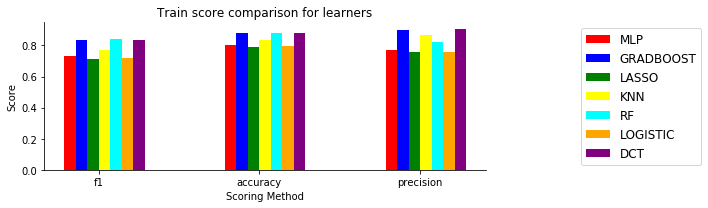

In [28]:
fig = plt.figure(figsize = (7,3))
colordict = ['red','blue','green','yellow','cyan','orange','purple']

ax = plt.gca()

for j in range(0,len(model_list)):
    yy = ensemble_scores_train[model_list[j]]
    xx = list(np.arange(0,len(performance_measures))*2+j*1/len(model_list))


    ax.bar(xx, height = yy,width=1/len(model_list),color=colordict[j],align='center',label=model_list[j])

ax.legend(loc='upper right', bbox_to_anchor=(1.5, 1), fontsize = 12)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt_name = "Train score comparison for learners"
ax.set_title(plt_name)
ax.set_xlabel('Scoring Method')
ax.set_ylabel('Score')
ax.set_xticklabels(performance_measures)
plt.xticks(list(np.arange(0,len(performance_measures))*2+j*1/len(model_list)-0.5), performance_measures) 

ax.tick_params(axis='x',which='both',top='off') # labels along the bottom edge are off
ax.tick_params(axis='y',which='both',right='off') # labels along the bottom edge are off

fig.tight_layout()
plt.show()


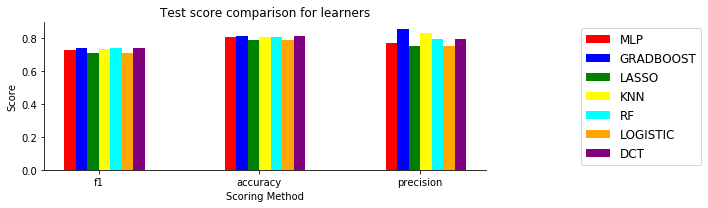

In [29]:
fig = plt.figure(figsize = (7,3))
colordict = ['red','blue','green','yellow','cyan','orange','purple']

ax = plt.gca()

for j in range(0,len(model_list)):
    yy = ensemble_scores_test[model_list[j]]
    xx = list(np.arange(0,len(performance_measures))*2+j*1/len(model_list))


    ax.bar(xx, height = yy,width=1/len(model_list),color=colordict[j],align='center',label=model_list[j])

ax.legend(loc='upper right', bbox_to_anchor=(1.5, 1), fontsize = 12)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt_name = "Test score comparison for learners"
ax.set_title(plt_name)
ax.set_xlabel('Scoring Method')
ax.set_ylabel('Score')
ax.set_xticklabels(performance_measures)
plt.xticks(list(np.arange(0,len(performance_measures))*2+j*1/len(model_list)-0.5), performance_measures) 

ax.tick_params(axis='x',which='both',top='off') # labels along the bottom edge are off
ax.tick_params(axis='y',which='both',right='off') # labels along the bottom edge are off

fig.tight_layout()
plt.show()



### Compare Train vs Test for Scoring Methods
I am using the accuracy measure. It computes the fraction of predictions where our mmodel predicted the correct class. There are other measures that exist, for example precision that is interested in how good our model is at predicting positives. That is, if we are only interested in how well we can predict survivors precision tells us how accurate we were in predicting survivors. My argument is that I want to be as accurate as possible whether someone will die or survive as this is really a life and death situation, and I can't afford to be wrong.

In both the training (using 10 fold CV) and testing (predicting the whole training set - since we don't have data on the ultimate testing set as to who survived or not I can't use this) Gradient Boosting and Decision Tree Classifier is outperforming, with Gradient Boost taking a slight lead in accuracy in training, where as DTC takes a very slight edge in testing. I suspect this is as a result of the variables I'm feeding into the models. I've constrained them to the variables I originally scoped out, and thus I think items such as MLP or GradientBoost can't come to their full pwer to learn the features that would improve the scores.

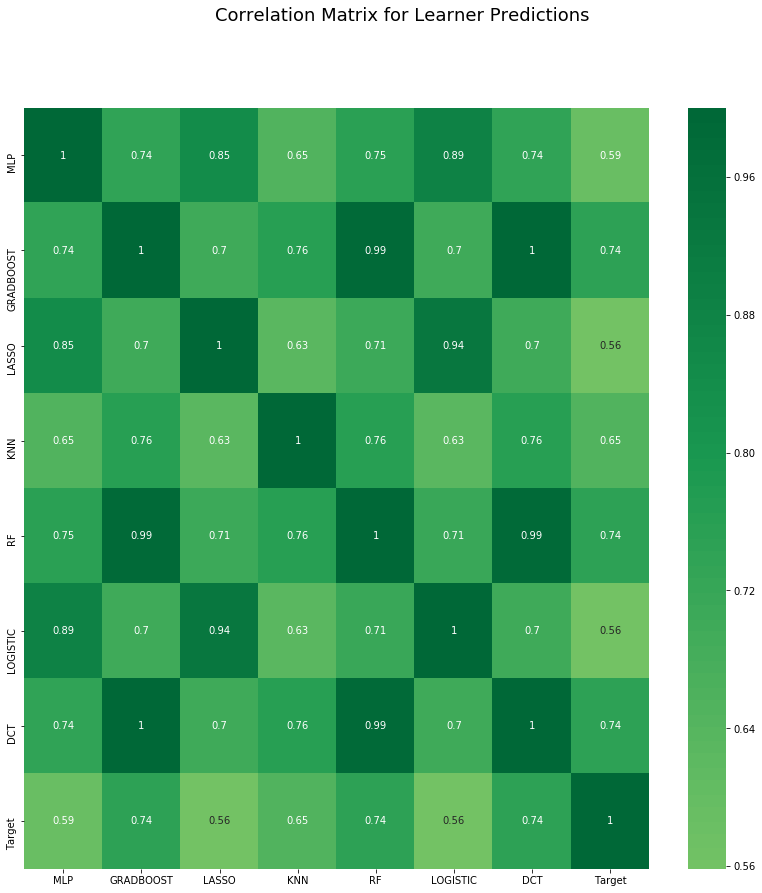

In [30]:
PredictionsWithSurvival = Predictions.copy()

PredictionsWithSurvival["Target"]= new_train_data['Survived']

fig = plt.figure(figsize=(14,14))
CorMat2 = PredictionsWithSurvival.corr()
sns.heatmap(CorMat2, annot=True, center=0, cmap = 'RdYlGn');
plt.suptitle('Correlation Matrix for Learner Predictions', fontsize=18)

plt.show()


### 3.2 Error analysis

Perform some error analysis to gain some intuition for where your models are not performing well. Are your models all having problems with the same individuals? Inspect this manually and report your results.

Now, do this a bit more systematically by creating a correlation matrix showing the correlation in predictions between each model. In other words, treat the output of each of your *M* models as a binary vector with one entry for each of the test data, and show how these prediction vectors relate to each other by plotting the *M* x *M* matrix of correlation coefficients. What do you observe?

In [31]:
# Enter your code here
PredictionsWithSurvival['SumModels'] = np.sum(Predictions[model_list], axis = 1)
print("cases where all models predict 1 (survived) and target is 0 (died)")
print(new_train_data.loc[(PredictionsWithSurvival['SumModels']==7) & (PredictionsWithSurvival['Target']==0)])
print("cases where all models predict 1 (survived) except one model and target is 0 (died)")
print(new_train_data.loc[(PredictionsWithSurvival['SumModels']==6) & (PredictionsWithSurvival['Target']==0)])
print('\n')
print("cases where all models predict 0 (died) and target is 1 (survived)")
print(new_train_data.loc[(PredictionsWithSurvival['SumModels']==0) & (PredictionsWithSurvival['Target']==1)])
print("cases where all models predict 0 (died) except one model and target is 1 (survived)")
print(new_train_data.loc[(PredictionsWithSurvival['SumModels']==1) & (PredictionsWithSurvival['Target']==1)])
print('\n')

cases where all models predict 1 (survived) and target is 0 (died)
             Survived  Pclass                                    Name     Sex  \
PassengerId                                                                     
72                  0       3              goodwin, miss. lillian amy  female   
200                 0       2  yrois, miss. henriette ("mrs harbeck")  female   

              Age  SibSp  Parch   Ticket  Fare Cabin    ...    Pclass_1  \
PassengerId                                             ...               
72           16.0      5      2  CA 2144  46.9   NaN    ...           0   
200          24.0      0      0   248747  13.0   NaN    ...           0   

            Pclass_2 Pclass_3  Sex_enc  Title_enc  Pclass_enc  Sex_enc_std  \
PassengerId                                                                  
72                 0        1        0          1           2    -1.355574   
200                1        0        0          3           1    -1.35557

*Enter your observations here*
### Classification errors
Interestingly, the model is making mistakes as follows
- there are some females that unfortunately died, and the model keeps on predicting that they would survive. This is understandable given that sex is the feature with most importance.
- similarly there are some males that survived but the model keeps predicting that they would die. Just as with the females this makes sense because of the feature importance.
If we wanted to get a better average score between the two then perhaps looking at something like F1 would be better.

### Correlations
Interestingly models that are in the same family, seems to correlate quite well. For exmaple, Random forrests, Decision Trees and Gradient Boost have quite high correlations. Lasso and Logistic have a high correlation. The models that we ultimately choose, Gradient Boost and Decision Tree Classifier have the highest correlation with the target values.

### 3.3 Develop an ensemble

Create an ensemble learner by hand. Using all of the training data, fit each of the models in 3.1. Then, classify each instance in the test data by taking the majority vote of all of your different fitted models. How accurately do you predict survival? How does this compare to your earlier results? 

*Note:* You will have to decide how to handle tie votes

In [33]:
# Enter your code here

PredictionsWithSurvival = Predictions.copy()
#reusing the CV fitted models and predictions from before"
PredictionsWithSurvival["Target"]= new_train_data['Survived']
if len(model_list) % 2 == 0:
    Majority = np.ceil(len(model_list)/2)+1
else:
    Majority = np.ceil(len(model_list)/2)       
#there will be no tie votes as we want majority always thus 5 out of 8 or 4 out of 7 etc.
PredictionsWithSurvival['Ensemble'] = np.sum(Predictions[model_list], axis = 1) > Majority
PredictionsWithSurvival['Ensemble'] = PredictionsWithSurvival['Ensemble'].astype(int)

print('Accuracy: ', accuracy_score(y_pred= PredictionsWithSurvival['Ensemble'],y_true = PredictionsWithSurvival['Target']))


Accuracy:  0.856341189675


*Enter your observations here*
The accuracy is quite a lot better for the whole dataset. We are getting 85.6% vs 81% previously.
I'm just using pure majority, so where more than half of the number of models voted survived, we said survived.

### 3.4 What can we learn from the models?

Revisit your analysis from in part 1.2, now that you have deployed several machine learning models on the task of predicting survival. For each of the models that you fitted in 3.1, do your best to interpret the model itself, and summarize what the model tells you about the factors that were most important in determining survival on the Titanic. Are all of the models telling you the same thing, or do different models suggest different explanations?

In [34]:
# Enter your code here
# model_list = ['MLP','GRADBOOST','LASSO','KNN','RF','LOGISTIC','DCT']
print("Variables we fit" +str(LogitVars))
MLPP = modelsFit['MLP'].best_estimator_
print("MLP Coefficients")
print(MLPP.coefs_)
print("\n")
print("Variables we fit" +str(LogitVars))
GRADBOOSTT = modelsFit['GRADBOOST'].best_estimator_
print("Gradient Boost Rank of Features")
print(ss.rankdata(GRADBOOSTT.feature_importances_*-1))
print("\n")
LASSOO = modelsFit['LASSO'].best_estimator_
print("Lasso Rank of Features")
print(ss.rankdata(LASSOO.coef_))
print("\n")
KNNN = modelsFit['KNN'].best_estimator_
print("Knn Effective Metric")
print(KNNN.effective_metric_)
print("\n")
RFF = modelsFit['RF'].best_estimator_
print("Random Forrest Rank of Features")
print(ss.rankdata(RFF.feature_importances_*-1))
print("\n")
LOGISTICC = modelsFit['LOGISTIC'].best_estimator_
print("Logistic Rank of Features")
print(ss.rankdata(LOGISTICC.coef_))
print("\n")
DCTT = modelsFit['DCT'].best_estimator_
print("Decision Tree Rank of Features")
print(ss.rankdata(DCTT.feature_importances_*-1))

Variables we fit['Pclass_enc_std', 'Title_enc_std', 'Sex_enc_std', 'Age_std']
MLP Coefficients
[array([[ 0.07483457,  0.15319015,  0.03026417, -0.09304748,  0.19666445,
        -0.28939823, -0.24707461,  0.01648965, -0.00193158, -0.21171071,
         0.06729985,  0.20051399,  0.4442076 , -0.33806107, -0.33124686,
        -0.35206616,  0.16346757,  0.26140886, -0.07298079,  0.00668691,
         0.11096508, -0.17309074, -0.03789257, -0.00761386, -0.06959031,
        -0.14367971, -0.04105937,  0.27421122,  0.33371711, -0.23744904,
        -0.01400756,  0.01821041, -0.09945978,  0.17960225,  0.36613331,
         0.17448067, -0.21299591, -0.06928626,  0.12937289, -0.05853169,
        -0.31638797, -0.05082323,  0.11365961, -0.07516631,  0.00868268,
         0.37278282, -0.37973226,  0.2880635 , -0.15311782,  0.18860312,
        -0.29966276,  0.37062943,  0.29882242, -0.2390644 , -0.30047946,
        -0.1387083 ,  0.19339749, -0.05526859,  0.38779298, -0.2626918 ,
        -0.39605369, -0.3329

*Enter your observations here*

Given the MLP setup it is very difficult to reconcile the importance of the features. We can probably figure this out by removing them one for one and then observing the impact. We would also have to do this for KNN, to determine how effective our model (or rather what the reduction in accuracy is) from removing one feature.
Lasso and Logistic have the same ranking and are of the same model type.
Gradient Boost and Decision Tree have the same rank of features.
Random boost has its own order and interestingly deviates from putting sex first, it's most important feature is Age.
